#### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License

# Classification on imbalanced data
## Modified by Mike Bopf for CSL data

## Setup

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data processing and exploration

### Substitute CSL (binned and encoded) for Kaggle fraud

In [4]:
# Read in data with an optional subset to shorten testing time
# If reshape=True, return 2d array values
def load_dataset(filename, cramer_coef, target, var_count, row_count, reshape=False):
    df = pd.read_csv(filename, index_col=0, header=0, nrows=row_count)
    
    # split into input (X) and output (y) variables
    X = df.drop(target, axis=1, inplace=False)
    
    # order columns by Cramer coeffs
    cramer_df = pd.read_csv(cramer_coef, sep='\t', header=None)
    cols = cramer_df.iloc[:, 0].tolist()
    X = X[cols]
    y = df[target]
    
    # Reduce # of variables
    if var_count < X.shape[1]:
        X = X.iloc[:, 0:var_count]
        
    # reshape target to be a 2d array, if flag set
    if reshape:
        y = df[target].values
        y = y.reshape((len(y), 1))
        X = X.values

    return X, y 

In [5]:
from IPython.display import display
from collections import Counter
X, y = load_dataset('/MFMDatasets/MFM_bopf/data/csl/CSL_tl_PI_encoded.csv', 
                    '/MFMDatasets/MFM_bopf/data/csl/CramerTheil/Cramer_PI_Tl_coeff_ALL.csv', 
                    'trans_loss', 50, 200000, reshape=False)
display(X.head())
Counter(y)

,Delmode,HxnumCS,TrialLabor,ROMmeth,Inoxy_incrdose,Dilat_lst,Insurance,Admcontract,BESTGA,Admpresent,...,momrace_new,Admconsistency,Anteprevia,IntraMgSO,spontlabor,Admcervpos,Admreason,Intrafetdistress,Antesteroid,Anteabruption
0,4,1,0,0,3,3,0,0,4,13,...,0,3,0,0,1,3,0,0,0,0
1,0,0,1,0,3,3,0,1,4,0,...,0,1,0,0,0,2,2,0,0,0
2,0,0,1,0,3,2,0,2,4,0,...,0,1,0,0,0,2,2,0,0,0
3,0,0,1,1,3,5,0,2,4,13,...,0,2,0,0,1,1,3,0,0,0
4,0,0,1,1,3,4,0,2,4,13,...,0,2,0,0,1,0,3,0,0,0


Counter({0: 175069, 1: 10344})

### Examine the class label imbalance

Let's look at the dataset imbalance:

In [6]:
neg, pos = np.bincount(y)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 185413
    Positive: 10344 (5.58% of total)



This shows the small fraction of positive samples.

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print(X_train.shape)
print(y_train.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=1)
X_train_f = np.array(X_train)
X_val_f = np.array(X_val)
X_test_f = np.array(X_test)
y_train_l = np.array(y_train)
y_val_l = np.array(y_val)
y_test_l = np.array(y_test)
print(X_train_f.shape)
print(y_train.shape)
print(X_test_f.shape)
print(y_test.shape)
print(X_val_f.shape)
print(y_val.shape)
print(type(y_val_l), type(X_train_f))
print(type(y_test_l))
print(X_train_f[0:3])

(148330, 50)
(148330,)
(118664, 50)
(118664,)
(37083, 50)
(37083,)
(29666, 50)
(29666,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[[ 3  9  1  5  0  3  1  0  4  0  8  1  0  0  1  0  1  0  3  0  0  4  0  1
   1  0  0  8  0  0  0  0  0  0  0  0  0  0  1  1  1  3  0  0  0  3  5  0
   0  0]
 [ 0  0  1  0  1  5  0  1  4  0  8  1  0  0  1  0  0  0  3  0  0  5  8  4
   1  4  0  8  0  0  2  0  6 13  0  0  0  0  1  1  5  2  0  0  1  0  3  0
   0  0]
 [ 3  0  1  0  2  0  0  4  4  0  5  1  0  0  1  0  1  0  3  0  0  4  7  4
   0  0  0  8  1  0  2  1  2 13  0  0  0  0  0  1  1  3  0  0  0  3  2  1
   0  0]]


Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.


### Look at the data distribution

Next compare the distributions of the positive and negative examples over a few features. Good questions to ask yourself at this point are:

* Do these distributions make sense? 
    * Yes. You've normalized the input and these are mostly concentrated in the `+/- 2` range.
* Can you see the difference between the distributions?
    * Yes the positive examples contain a much higher rate of extreme values.

/opt/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


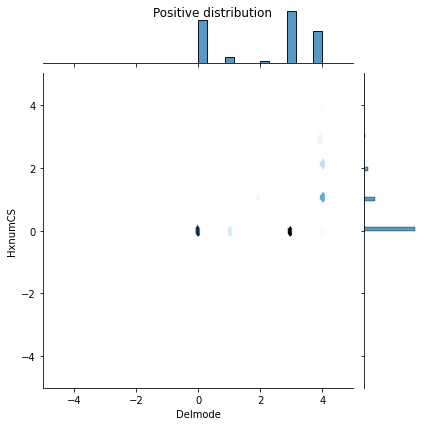

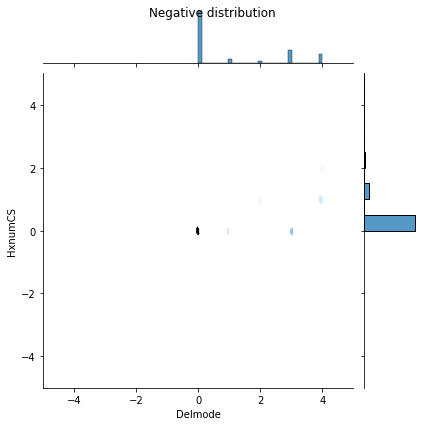

In [8]:
pos_df = pd.DataFrame(X_train_f[y_train_l == 1], columns=X_train.columns)
neg_df = pd.DataFrame(X_train_f[y_train_l == 0], columns=X_train.columns)

sns.jointplot(pos_df['Delmode'], pos_df['HxnumCS'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['Delmode'], neg_df['HxnumCS'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

In [9]:
import keras.backend as K
import tensorflow_addons as tfa

# Credit: Arnaldo Gualberto
def mcc(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())

# Note - this does not appear to be calculating F2 correctly...
# Credit: Arnaldo Gualberto
def f2(y_true, y_pred, beta=2):
    y_pred = K.clip(y_pred, 0, 1)

    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    num = (1 + beta ** 2) * (p * r)
    den = (beta ** 2 * p + r + K.epsilon())
    #return K.mean(num / den)
    return num/den



# Credit: Arnaldo Gualberto
def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())

# Normalized True Positive
def ntp(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return int(tp * 10000 / (tp + fp + fn + tn))

# Normalized True Negative
def nfn(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return int(fn * 10000 / (tp + fp + fn + tn))

# Normalized True Negative
def nfp(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return int(fp * 10000 / (tp + fp + fn + tn))

# Normalized True Negative
def ntn(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return int(tn * 10000 / (tp + fp + fn + tn))

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      mcc, f2, specificity, ntp, nfn, nfp, ntn,
      tfa.metrics.FBetaScore(num_classes=2, beta=2.0, average='micro'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(X_train_f.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [10]:
# Simplified F2 calculation
def fbeta2 (prec, recall):
    return (5 * prec * recall)/(4 * prec + recall)

In [11]:
input_shape = (X_train_f.shape[-1],)
print(input_shape)

(50,)


## Baseline model

### Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


Note: this model will not handle the class imbalance well. You will improve it later in this tutorial.

In [12]:
EPOCHS = 100  
#EPOCHS = 3
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


Test run the model:

In [14]:
model.predict(X_train_f[:10])

array([[0.857777  ],
       [0.0220606 ],
       [0.20325223],
       [0.9865763 ],
       [0.0206399 ],
       [0.89188546],
       [0.9780861 ],
       [0.14231592],
       [0.55406415],
       [0.7134    ]], dtype=float32)

### Optional: Set the correct initial bias.

These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that (See: [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)). This can help with initial convergence.

With the default bias initialization the loss should be about `math.log(2) = 0.69314` 

In [15]:
results = model.evaluate(X_train_f, y_train_l, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.7264


The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [16]:
print(f'pos = {pos}; neg = {neg}')

pos = 10344; neg = 175069


In [17]:
initial_bias = np.log([pos/neg])
initial_bias

array([-2.82877354])

In [18]:
#Set that as the initial bias, and the model will give much more reasonable initial guesses. 
print(f'Bias should be near: pos/(pos+neg)={pos/(pos+neg)} ')

Bias should be near: pos/(pos+neg)=0.055788968411060715 


In [19]:
model = make_model(output_bias=initial_bias)
model.predict(X_train_f[:10])

array([[0.04303706],
       [0.8158289 ],
       [0.57230836],
       [0.49109793],
       [0.90159595],
       [0.60234547],
       [0.63618374],
       [0.4650731 ],
       [0.70792496],
       [0.3855895 ]], dtype=float32)

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [20]:
p_0 = pos/(pos+neg)
b0 = -p_0 * np.log(p_0) - (1 - p_0) * np.log(1-p_0)
b0

0.21521994509895337

In [21]:
results = model.evaluate(X_train_f, y_train_l, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.0886


This initial loss is about 50 times less than if would have been with naive initialization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [22]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses: 

In [23]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train_f,
    y_train_l,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val_f, y_val_l), 
    verbose=0)

In [24]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train_f,
    y_train_l,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val_f, y_val_l), 
    verbose=0)

In [25]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

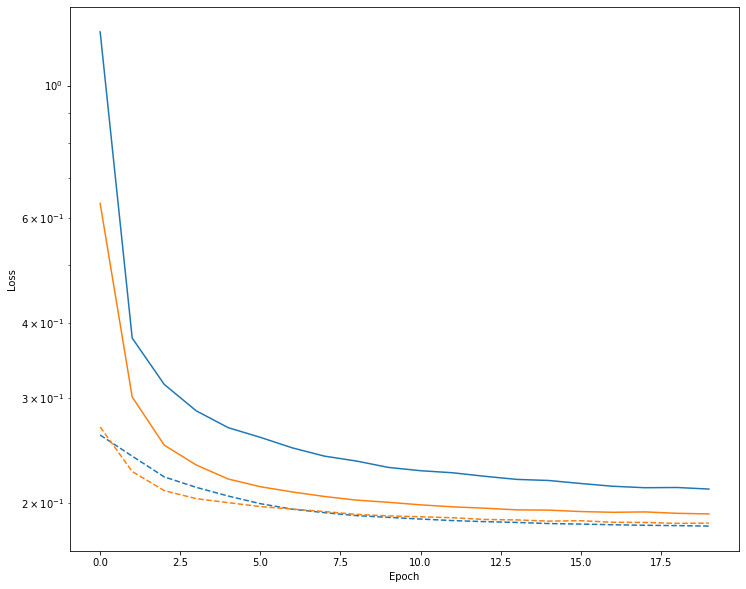

In [26]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage. 

### Train the model

In [27]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train_f,
    y_train_l,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val_f, y_val_l))

Epoch 1/100
58/58 [==============================] - 8s 74ms/step - loss: 0.9726 - tp: 708.2542 - fp: 12692.7458 - tn: 73283.4068 - fn: 4382.8136 - accuracy: 0.8124 - precision: 0.0536 - recall: 0.1413 - mcc: -0.0076 - f2: 0.0148 - specificity: 0.7275 - ntp: 147.6259 - nfn: 413.0014 - nfp: 2570.7159 - ntn: 6866.8555 - fbeta_score: 0.2285 - auc: 0.6025 - prc: 0.0677 - val_loss: 0.2646 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 28011.0000 - val_fn: 1655.0000 - val_accuracy: 0.9442 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mcc: 0.0000e+00 - val_f2: 0.0000e+00 - val_specificity: 1.0000 - val_ntp: 0.0000e+00 - val_nfn: 558.9333 - val_nfp: 0.0000e+00 - val_ntn: 9440.0664 - val_fbeta_score: 0.2280 - val_auc: 0.6330 - val_prc: 0.0851
Epoch 2/100
58/58 [==============================] - 2s 29ms/step - loss: 0.3190 - tp: 68.2203 - fp: 1535.7119 - tn: 56434.2881 - fn: 3363.0000 - accuracy: 0.9194 - precision: 0.0420 - recall: 0.0207 - mcc: -0.0100 - f2: 0.0011 - specific

Epoch 12/100
58/58 [==============================] - 2s 34ms/step - loss: 0.1984 - tp: 3.1695 - fp: 5.4576 - tn: 57954.2034 - fn: 3438.3898 - accuracy: 0.9438 - precision: 0.3869 - recall: 0.0010 - mcc: 0.0099 - f2: 5.8533e-05 - specificity: 0.9999 - ntp: 0.4795 - nfn: 560.7780 - nfp: 0.7475 - ntn: 9436.7540 - fbeta_score: 0.2294 - auc: 0.7268 - prc: 0.1152 - val_loss: 0.1885 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 28011.0000 - val_fn: 1655.0000 - val_accuracy: 0.9442 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mcc: 0.0000e+00 - val_f2: 0.0000e+00 - val_specificity: 1.0000 - val_ntp: 0.0000e+00 - val_nfn: 558.9333 - val_nfp: 0.0000e+00 - val_ntn: 9440.0664 - val_fbeta_score: 0.2280 - val_auc: 0.7850 - val_prc: 0.1464
Epoch 13/100
58/58 [==============================] - 2s 30ms/step - loss: 0.1968 - tp: 0.7288 - fp: 8.2373 - tn: 57981.5763 - fn: 3410.6780 - accuracy: 0.9440 - precision: 0.0743 - recall: 1.9169e-04 - mcc: 7.6455e-04 - f2: 1.0616e-05 - specifi

Epoch 23/100
58/58 [==============================] - 2s 31ms/step - loss: 0.1892 - tp: 5.7627 - fp: 7.8136 - tn: 57975.3559 - fn: 3412.2881 - accuracy: 0.9443 - precision: 0.4145 - recall: 0.0017 - mcc: 0.0147 - f2: 9.4983e-05 - specificity: 0.9999 - ntp: 0.7781 - nfn: 555.1514 - nfp: 1.1044 - ntn: 9441.6238 - fbeta_score: 0.2276 - auc: 0.7682 - prc: 0.1367 - val_loss: 0.1834 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 28011.0000 - val_fn: 1655.0000 - val_accuracy: 0.9442 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mcc: 0.0000e+00 - val_f2: 0.0000e+00 - val_specificity: 1.0000 - val_ntp: 0.0000e+00 - val_nfn: 558.9333 - val_nfp: 0.0000e+00 - val_ntn: 9440.0664 - val_fbeta_score: 0.2280 - val_auc: 0.8042 - val_prc: 0.1698
Epoch 24/100
58/58 [==============================] - 2s 29ms/step - loss: 0.1907 - tp: 5.2203 - fp: 8.6441 - tn: 57930.6441 - fn: 3456.7119 - accuracy: 0.9435 - precision: 0.3264 - recall: 0.0012 - mcc: 0.0096 - f2: 7.0385e-05 - specificity: 0.

Epoch 34/100
58/58 [==============================] - 2s 34ms/step - loss: 0.1838 - tp: 15.8644 - fp: 15.1186 - tn: 57982.1017 - fn: 3388.1356 - accuracy: 0.9450 - precision: 0.4844 - recall: 0.0045 - mcc: 0.0348 - f2: 2.4687e-04 - specificity: 0.9997 - ntp: 2.0701 - nfn: 547.0192 - nfp: 2.1907 - ntn: 9446.9784 - fbeta_score: 0.2254 - auc: 0.7802 - prc: 0.1533 - val_loss: 0.1805 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 28011.0000 - val_fn: 1655.0000 - val_accuracy: 0.9442 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mcc: 0.0000e+00 - val_f2: 0.0000e+00 - val_specificity: 1.0000 - val_ntp: 0.0000e+00 - val_nfn: 558.9333 - val_nfp: 0.0000e+00 - val_ntn: 9440.0664 - val_fbeta_score: 0.2280 - val_auc: 0.8121 - val_prc: 0.1807
Epoch 35/100
58/58 [==============================] - 2s 31ms/step - loss: 0.1873 - tp: 15.2034 - fp: 18.8814 - tn: 57944.7966 - fn: 3422.3390 - accuracy: 0.9438 - precision: 0.3994 - recall: 0.0040 - mcc: 0.0281 - f2: 2.2399e-04 - specificity

Epoch 45/100
58/58 [==============================] - 2s 31ms/step - loss: 0.1853 - tp: 14.4576 - fp: 15.4746 - tn: 57949.5763 - fn: 3421.7119 - accuracy: 0.9435 - precision: 0.4572 - recall: 0.0041 - mcc: 0.0304 - f2: 2.2869e-04 - specificity: 0.9997 - ntp: 1.9370 - nfn: 561.4724 - nfp: 2.3390 - ntn: 9432.4562 - fbeta_score: 0.2302 - auc: 0.7876 - prc: 0.1590 - val_loss: 0.1793 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 28010.0000 - val_fn: 1655.0000 - val_accuracy: 0.9442 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mcc: -3.5105e-04 - val_f2: 0.0000e+00 - val_specificity: 1.0000 - val_ntp: 0.0000e+00 - val_nfn: 558.9333 - val_nfp: 0.2667 - val_ntn: 9439.7998 - val_fbeta_score: 0.2280 - val_auc: 0.8154 - val_prc: 0.1876
Epoch 46/100
58/58 [==============================] - 2s 33ms/step - loss: 0.1832 - tp: 11.7966 - fp: 18.6610 - tn: 57981.3729 - fn: 3389.3898 - accuracy: 0.9445 - precision: 0.3759 - recall: 0.0036 - mcc: 0.0263 - f2: 2.0029e-04 - specificity: 0.999

Epoch 56/100
58/58 [==============================] - 2s 27ms/step - loss: 0.1813 - tp: 13.4576 - fp: 22.7627 - tn: 57967.8305 - fn: 3397.1695 - accuracy: 0.9444 - precision: 0.3765 - recall: 0.0042 - mcc: 0.0292 - f2: 2.3426e-04 - specificity: 0.9996 - ntp: 2.0800 - nfn: 551.2053 - nfp: 3.2730 - ntn: 9441.7422 - fbeta_score: 0.2268 - auc: 0.7980 - prc: 0.1667 - val_loss: 0.1781 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 28010.0000 - val_fn: 1655.0000 - val_accuracy: 0.9442 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mcc: -3.5105e-04 - val_f2: 0.0000e+00 - val_specificity: 1.0000 - val_ntp: 0.0000e+00 - val_nfn: 558.9333 - val_nfp: 0.2667 - val_ntn: 9439.7998 - val_fbeta_score: 0.2280 - val_auc: 0.8178 - val_prc: 0.1910
Epoch 57/100
58/58 [==============================] - 2s 27ms/step - loss: 0.1821 - tp: 12.1356 - fp: 25.7288 - tn: 57935.7288 - fn: 3427.6271 - accuracy: 0.9440 - precision: 0.3039 - recall: 0.0036 - mcc: 0.0231 - f2: 1.9892e-04 - specificity: 0.999

Epoch 67/100
58/58 [==============================] - 2s 28ms/step - loss: 0.1829 - tp: 15.6610 - fp: 16.4237 - tn: 57941.3051 - fn: 3427.8305 - accuracy: 0.9437 - precision: 0.5104 - recall: 0.0049 - mcc: 0.0375 - f2: 2.7482e-04 - specificity: 0.9997 - ntp: 2.3597 - nfn: 560.0097 - nfp: 2.1875 - ntn: 9433.5249 - fbeta_score: 0.2298 - auc: 0.7958 - prc: 0.1663 - val_loss: 0.1776 - val_tp: 0.0000e+00 - val_fp: 2.0000 - val_tn: 28009.0000 - val_fn: 1655.0000 - val_accuracy: 0.9441 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mcc: -4.9658e-04 - val_f2: 0.0000e+00 - val_specificity: 0.9999 - val_ntp: 0.0000e+00 - val_nfn: 558.9333 - val_nfp: 0.6000 - val_ntn: 9439.4668 - val_fbeta_score: 0.2280 - val_auc: 0.8191 - val_prc: 0.1942
Epoch 68/100
58/58 [==============================] - 1s 22ms/step - loss: 0.1819 - tp: 17.6441 - fp: 26.1695 - tn: 57927.5254 - fn: 3429.8814 - accuracy: 0.9441 - precision: 0.3626 - recall: 0.0047 - mcc: 0.0340 - f2: 2.6193e-04 - specificity: 0.999

Epoch 78/100
58/58 [==============================] - 2s 29ms/step - loss: 0.1801 - tp: 14.9661 - fp: 17.1525 - tn: 57985.2712 - fn: 3383.8305 - accuracy: 0.9450 - precision: 0.4989 - recall: 0.0050 - mcc: 0.0353 - f2: 2.7277e-04 - specificity: 0.9997 - ntp: 2.4228 - nfn: 546.9810 - nfp: 2.2869 - ntn: 9446.7037 - fbeta_score: 0.2255 - auc: 0.8004 - prc: 0.1686 - val_loss: 0.1773 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 28010.0000 - val_fn: 1655.0000 - val_accuracy: 0.9442 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mcc: -3.5105e-04 - val_f2: 0.0000e+00 - val_specificity: 1.0000 - val_ntp: 0.0000e+00 - val_nfn: 558.9333 - val_nfp: 0.2667 - val_ntn: 9439.7998 - val_fbeta_score: 0.2280 - val_auc: 0.8210 - val_prc: 0.1952
Epoch 79/100
58/58 [==============================] - 2s 33ms/step - loss: 0.1815 - tp: 14.8305 - fp: 21.1525 - tn: 57965.2203 - fn: 3400.0169 - accuracy: 0.9442 - precision: 0.3827 - recall: 0.0042 - mcc: 0.0249 - f2: 2.3137e-04 - specificity: 0.999

Epoch 89/100
58/58 [==============================] - 2s 33ms/step - loss: 0.1815 - tp: 17.0000 - fp: 29.0508 - tn: 57951.4407 - fn: 3403.7288 - accuracy: 0.9443 - precision: 0.3832 - recall: 0.0056 - mcc: 0.0367 - f2: 3.0973e-04 - specificity: 0.9995 - ntp: 2.6966 - nfn: 551.6391 - nfp: 4.3172 - ntn: 9439.3793 - fbeta_score: 0.2272 - auc: 0.7968 - prc: 0.1694 - val_loss: 0.1770 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 28010.0000 - val_fn: 1655.0000 - val_accuracy: 0.9442 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mcc: -3.5105e-04 - val_f2: 0.0000e+00 - val_specificity: 1.0000 - val_ntp: 0.0000e+00 - val_nfn: 558.9333 - val_nfp: 0.2667 - val_ntn: 9439.7998 - val_fbeta_score: 0.2280 - val_auc: 0.8218 - val_prc: 0.1963
Epoch 90/100
58/58 [==============================] - 2s 31ms/step - loss: 0.1812 - tp: 23.2203 - fp: 24.0678 - tn: 57913.8475 - fn: 3440.0847 - accuracy: 0.9435 - precision: 0.5008 - recall: 0.0070 - mcc: 0.0419 - f2: 3.9854e-04 - specificity: 0.999

Epoch 100/100
58/58 [==============================] - 1s 24ms/step - loss: 0.1780 - tp: 19.3729 - fp: 22.5932 - tn: 57964.0339 - fn: 3395.2203 - accuracy: 0.9447 - precision: 0.4471 - recall: 0.0051 - mcc: 0.0374 - f2: 2.8444e-04 - specificity: 0.9996 - ntp: 2.4823 - nfn: 549.4839 - nfp: 3.0131 - ntn: 9443.2649 - fbeta_score: 0.2264 - auc: 0.8081 - prc: 0.1744 - val_loss: 0.1768 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 28010.0000 - val_fn: 1655.0000 - val_accuracy: 0.9442 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mcc: -3.5105e-04 - val_f2: 0.0000e+00 - val_specificity: 1.0000 - val_ntp: 0.0000e+00 - val_nfn: 558.9333 - val_nfp: 0.2667 - val_ntn: 9439.7998 - val_fbeta_score: 0.2280 - val_auc: 0.8210 - val_prc: 0.1968


### Check training history
In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [28]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

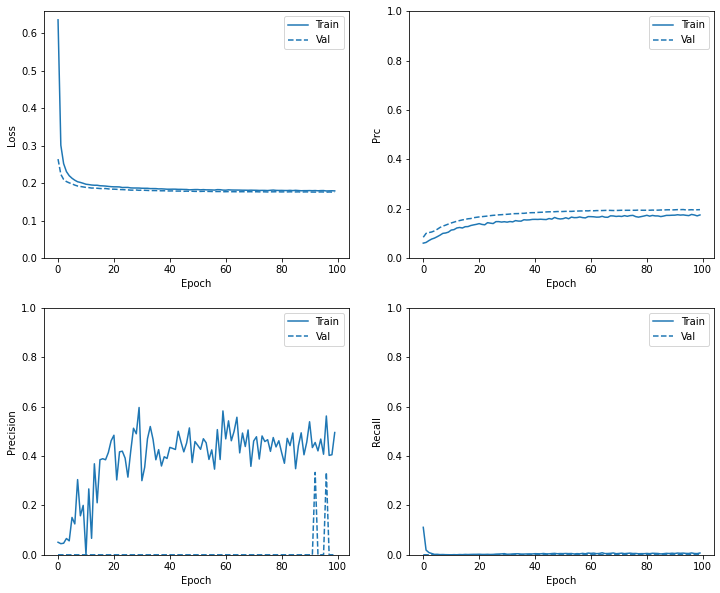

In [29]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels where the X axis is the predicted label and the Y axis is the actual label.

In [30]:
train_predictions_baseline = model.predict(X_train_f, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test_f, batch_size=BATCH_SIZE)

In [31]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives', cm[1][0])
  print('True Positives', cm[1][1])
  print('Total Positives: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above.

loss :  0.17561155557632446
tp :  0.0
fp :  1.0
tn :  35013.0
fn :  2069.0
accuracy :  0.9441792964935303
precision :  0.0
recall :  0.0
mcc :  -0.0002744722878560424
f2 :  0.0
specificity :  0.9999728798866272
ntp :  0.0
nfn :  554.8947143554688
nfp :  0.21052631735801697
ntn :  9443.841796875
fbeta_score :  0.22806939482688904
auc :  0.822075605392456
prc :  0.19724631309509277

True Negatives 35013
False Positives:  1
False Negatives 2069
True Positives 0
Total Positives:  2069


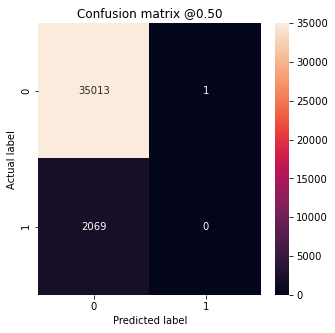

In [32]:
baseline_results = model.evaluate(X_test_f, y_test_l,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test_l, test_predictions_baseline)

If the model had predicted everything perfectly, this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [33]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
#  plt.xlim([-0.5,20])
#  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

Text(0.5, 1.0, 'ROC Curve')

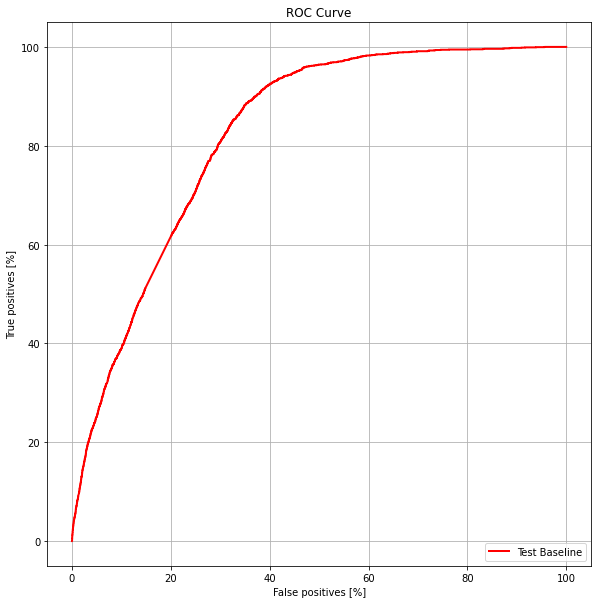

In [40]:
#plot_roc("Train Baseline", y_train_l, train_predictions_baseline, color='b')
#plot_roc("Test Baseline", y_test_l, test_predictions_baseline, color='g', linestyle='--')
plot_roc("Test Baseline", y_test_l, test_predictions_baseline, color='r')
plt.legend(loc='lower right')
plt.title('ROC Curve')

### Plot the PR
Now plot the [AUPRC](https://developers.google.com/machine-learning/glossary?hl=en#PR_AUC). Area under the interpolated precision-recall curve, obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.


In [35]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

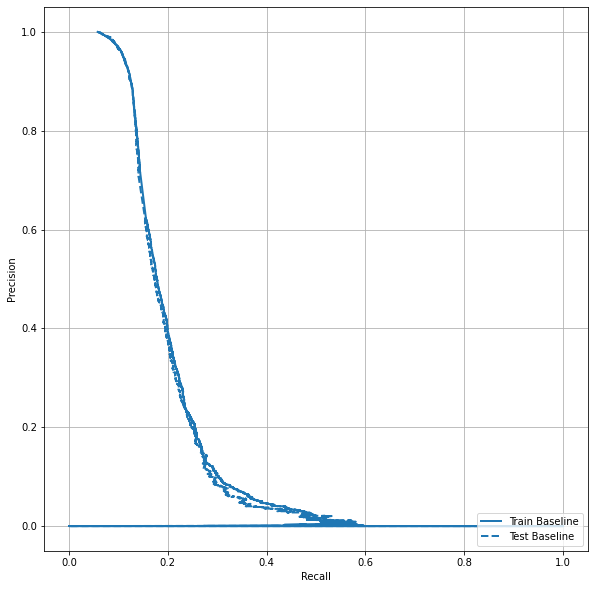

In [36]:
plot_prc("Train Baseline", y_train_l, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test_l, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

## Class weights

### Calculate class weights

The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [37]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.53
Weight for class 1: 8.96


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `optimizers.SGD`, may fail. The optimizer used here, `optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [38]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train_f,
    y_train_l,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val_f, y_val_l),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100
58/58 [==============================] - 8s 71ms/step - loss: 2.5411 - tp: 700.5763 - fp: 12699.9322 - tn: 80310.2203 - fn: 4773.4915 - accuracy: 0.8412 - precision: 0.0500 - recall: 0.1071 - mcc: -0.0107 - f2: 0.0095 - specificity: 0.8132 - ntp: 94.3660 - nfn: 458.0767 - nfp: 1764.1691 - ntn: 7681.2621 - fbeta_score: 0.2274 - auc: 0.6161 - prc: 0.0765 - val_loss: 0.5183 - val_tp: 470.0000 - val_fp: 7013.0000 - val_tn: 20998.0000 - val_fn: 1185.0000 - val_accuracy: 0.7237 - val_precision: 0.0628 - val_recall: 0.2840 - val_mcc: 0.0192 - val_f2: 0.0158 - val_specificity: 0.7493 - val_ntp: 160.1333 - val_nfn: 398.2667 - val_nfp: 2366.1333 - val_ntn: 7073.2666 - val_fbeta_score: 0.2280 - val_auc: 0.5419 - val_prc: 0.0627
Epoch 2/100
58/58 [==============================] - 2s 27ms/step - loss: 1.1564 - tp: 1076.7458 - fp: 15922.9831 - tn: 42067.1864 - fn: 2334.3051 - accuracy: 0.7013 - precision: 0.0625 - recall: 0.3145 - mcc: 0.0195 - f2: 0.0174 - specificity: 0.7239 - ntp: 17

58/58 [==============================] - 1s 25ms/step - loss: 0.6041 - tp: 2088.1864 - fp: 14601.7966 - tn: 43394.5085 - fn: 1316.7288 - accuracy: 0.7408 - precision: 0.1249 - recall: 0.6097 - mcc: 0.1841 - f2: 0.0339 - specificity: 0.7485 - ntp: 338.5312 - nfn: 216.5384 - nfp: 2374.1791 - ntn: 7068.7482 - fbeta_score: 0.2274 - auc: 0.7657 - prc: 0.1365 - val_loss: 0.5028 - val_tp: 1272.0000 - val_fp: 8329.0000 - val_tn: 19682.0000 - val_fn: 383.0000 - val_accuracy: 0.7063 - val_precision: 0.1325 - val_recall: 0.7686 - val_mcc: 0.2304 - val_f2: 0.0429 - val_specificity: 0.7029 - val_ntp: 427.9333 - val_nfn: 130.4000 - val_nfp: 2804.2666 - val_ntn: 6635.2666 - val_fbeta_score: 0.2280 - val_auc: 0.8069 - val_prc: 0.1705
Epoch 24/100
58/58 [==============================] - 2s 27ms/step - loss: 0.5960 - tp: 2128.7119 - fp: 14532.7797 - tn: 43461.1356 - fn: 1278.5932 - accuracy: 0.7441 - precision: 0.1283 - recall: 0.6255 - mcc: 0.1938 - f2: 0.0346 - specificity: 0.7510 - ntp: 345.6250 - n

58/58 [==============================] - 1s 15ms/step - loss: 0.5737 - tp: 2299.8136 - fp: 15454.3898 - tn: 42516.1017 - fn: 1130.9153 - accuracy: 0.7296 - precision: 0.1299 - recall: 0.6704 - mcc: 0.2046 - f2: 0.0376 - specificity: 0.7331 - ntp: 375.7022 - nfn: 184.4857 - nfp: 2518.9657 - ntn: 6919.1523 - fbeta_score: 0.2291 - auc: 0.7844 - prc: 0.1499 - val_loss: 0.5292 - val_tp: 1351.0000 - val_fp: 8926.0000 - val_tn: 19085.0000 - val_fn: 304.0000 - val_accuracy: 0.6889 - val_precision: 0.1315 - val_recall: 0.8163 - val_mcc: 0.2396 - val_f2: 0.0455 - val_specificity: 0.6814 - val_ntp: 455.1333 - val_nfn: 103.2667 - val_nfp: 3006.9333 - val_ntn: 6432.5332 - val_fbeta_score: 0.2280 - val_auc: 0.8150 - val_prc: 0.1818
Epoch 46/100
58/58 [==============================] - 1s 22ms/step - loss: 0.5720 - tp: 2283.1695 - fp: 15550.0339 - tn: 42423.9831 - fn: 1144.0339 - accuracy: 0.7284 - precision: 0.1283 - recall: 0.6637 - mcc: 0.2005 - f2: 0.0372 - specificity: 0.7323 - ntp: 371.5830 - n

58/58 [==============================] - 2s 30ms/step - loss: 0.5501 - tp: 2484.4746 - fp: 16439.4576 - tn: 41509.7288 - fn: 967.5593 - accuracy: 0.7185 - precision: 0.1331 - recall: 0.7233 - mcc: 0.2209 - f2: 0.0408 - specificity: 0.7182 - ntp: 407.5274 - nfn: 155.6335 - nfp: 2658.2548 - ntn: 6776.6681 - fbeta_score: 0.2301 - auc: 0.7956 - prc: 0.1607 - val_loss: 0.5277 - val_tp: 1431.0000 - val_fp: 9855.0000 - val_tn: 18156.0000 - val_fn: 224.0000 - val_accuracy: 0.6603 - val_precision: 0.1268 - val_recall: 0.8647 - val_mcc: 0.2420 - val_f2: 0.0482 - val_specificity: 0.6484 - val_ntp: 482.3333 - val_nfn: 76.1333 - val_nfp: 3318.9333 - val_ntn: 6120.6665 - val_fbeta_score: 0.2280 - val_auc: 0.8182 - val_prc: 0.1903
Epoch 68/100
58/58 [==============================] - 2s 34ms/step - loss: 0.5533 - tp: 2445.2373 - fp: 16587.0000 - tn: 41398.5593 - fn: 970.4237 - accuracy: 0.7139 - precision: 0.1294 - recall: 0.7208 - mcc: 0.2151 - f2: 0.0402 - specificity: 0.7134 - ntp: 401.7673 - nfn:

58/58 [==============================] - 1s 23ms/step - loss: 0.5388 - tp: 2742.0847 - fp: 18582.1356 - tn: 39372.7627 - fn: 704.2373 - accuracy: 0.6846 - precision: 0.1292 - recall: 0.8008 - mcc: 0.2314 - f2: 0.0451 - specificity: 0.6777 - ntp: 450.8974 - nfn: 111.8227 - nfp: 3040.8252 - ntn: 6394.6121 - fbeta_score: 0.2299 - auc: 0.7984 - prc: 0.1671 - val_loss: 0.4994 - val_tp: 1447.0000 - val_fp: 9972.0000 - val_tn: 18039.0000 - val_fn: 208.0000 - val_accuracy: 0.6568 - val_precision: 0.1267 - val_recall: 0.8743 - val_mcc: 0.2450 - val_f2: 0.0488 - val_specificity: 0.6442 - val_ntp: 488.8667 - val_nfn: 69.6667 - val_nfp: 3358.5334 - val_ntn: 6081.1333 - val_fbeta_score: 0.2280 - val_auc: 0.8209 - val_prc: 0.1942
Epoch 90/100
58/58 [==============================] - 2s 27ms/step - loss: 0.5300 - tp: 2696.8983 - fp: 18342.4746 - tn: 39636.1017 - fn: 725.7458 - accuracy: 0.6918 - precision: 0.1282 - recall: 0.7848 - mcc: 0.2274 - f2: 0.0436 - specificity: 0.6863 - ntp: 435.1756 - nfn:

### Check training history

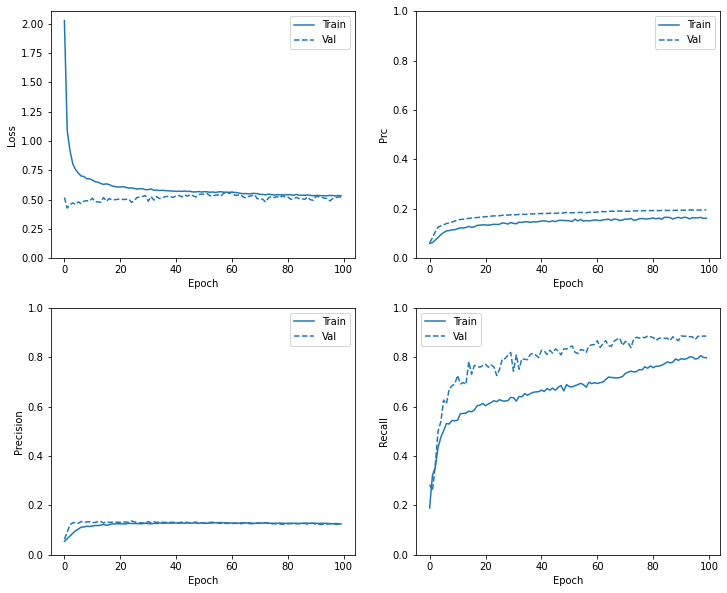

In [39]:
plot_metrics(weighted_history)

### Evaluate metrics

In [40]:
train_predictions_weighted = weighted_model.predict(X_train_f, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test_f, batch_size=BATCH_SIZE)
print(train_predictions_weighted)
print(test_predictions_weighted)

[[0.05494028]
 [0.15992472]
 [0.81300354]
 ...
 [0.6126133 ]
 [0.14956388]
 [0.6480975 ]]
[[1.3286939e-01]
 [2.3919019e-01]
 [6.6947937e-04]
 ...
 [1.6283002e-01]
 [1.4570355e-04]
 [6.0099316e-01]]


In [41]:
weighted_results = weighted_model.evaluate(X_test_f, y_test_l,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)

zip_iter = zip(weighted_model.metrics_names, weighted_results)
metric_dict = dict(zip_iter)
p = metric_dict['precision']
r = metric_dict['recall']
f2 = fbeta2(p, r)
print(f'f2 = {f2}')

loss :  0.5175259113311768
tp :  1848.0
fp :  12808.0
tn :  22206.0
fn :  221.0
accuracy :  0.6486530303955078
precision :  0.12609170377254486
recall :  0.8931851387023926
mcc :  0.247136190533638
f2 :  0.049834150820970535
specificity :  0.634440541267395
ntp :  495.9473571777344
nfn :  58.3684196472168
nfp :  3451.894775390625
ntn :  5991.73681640625
fbeta_score :  0.22806939482688904
auc :  0.8200139999389648
prc :  0.19099782407283783
f2 = 0.40293040848203515


True Negatives 22206
False Positives:  12808
False Negatives 221
True Positives 1848
Total Positives:  2069


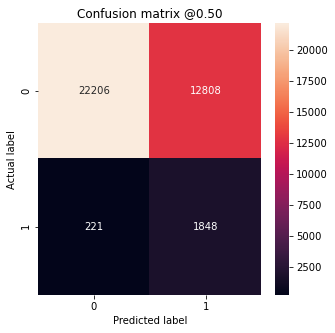

In [42]:
plot_cm(y_test_l, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade-offs between these different types of errors for your application.

### Plot the ROC

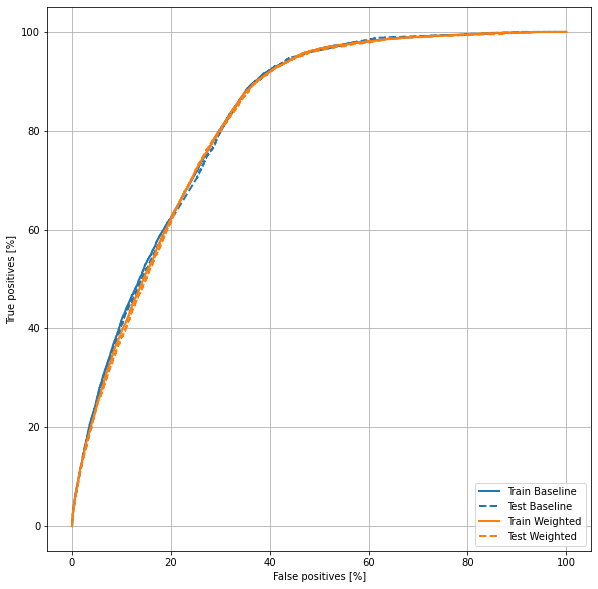

In [43]:
plot_roc("Train Baseline", y_train_l, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test_l, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train_l, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test_l, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

### Plot the AUPRC

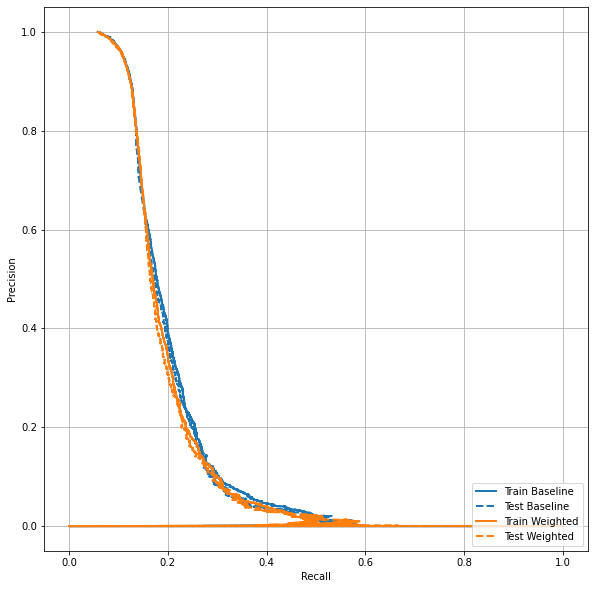

In [44]:
plot_prc("Train Baseline", y_train_l, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test_l, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train_l, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test_l, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

## Oversampling

### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [45]:
pos_features = X_train_f[y_train_l == 1]
neg_features = X_train_f[y_train_l == 0]

pos_labels = y_train_l[y_train_l == 1]
neg_labels = y_train_l[y_train_l == 0]

In [46]:
from collections import Counter
print(type(y_train_l))
print(Counter(y_train_l))
print(len(pos_features))
print(len(neg_features))
print(len(pos_labels))
print(len(neg_labels))

<class 'numpy.ndarray'>
Counter({0: 112044, 1: 6620})
6620
112044
6620
112044


#### Using NumPy

You can balance the dataset manually by choosing the right number of random 
indices from the positive examples:

In [47]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(112044, 50)

In [48]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(224088, 50)

#### Using `tf.data`

If you're using `tf.data` the easiest way to produce balanced examples is to start with a `positive` and a `negative` dataset, and merge them. See [the tf.data guide](../../guide/data.ipynb) for more examples.

In [49]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

Each dataset provides `(feature, label)` pairs:

In [50]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [ 4  1  0  0  1  3  0  0  2 13 18  3  0  0  3  1  1  1  3  0  1  5  3  4
  1  0  0  8  1  0  1  0 12 13  0  0  1  0  1  2  0  3  0  1  1  3  6  1
  0  1]

Label:  1


Merge the two together using `experimental.sample_from_datasets`:

In [51]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [52]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.50439453125


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [53]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

171.0

### Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps. 

In [54]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((X_val_f, y_val_l)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
171/171 [==============================] - 23s 112ms/step - loss: 1.3250 - tp: 45013.2558 - fp: 50176.0465 - tn: 73186.6919 - fn: 45847.0988 - accuracy: 0.5556 - precision: 0.4288 - recall: 0.4612 - mcc: 0.0460 - f2: 0.2172 - specificity: 0.6118 - ntp: 2171.8348 - nfn: 2842.2703 - nfp: 1934.9052 - ntn: 3048.9461 - fbeta_score: 0.7529 - auc: 0.5413 - prc: 0.4344 - val_loss: 0.6075 - val_tp: 1321.0000 - val_fp: 12242.0000 - val_tn: 15769.0000 - val_fn: 334.0000 - val_accuracy: 0.5761 - val_precision: 0.0974 - val_recall: 0.7982 - val_mcc: 0.1669 - val_f2: 0.0445 - val_specificity: 0.5633 - val_ntp: 446.7333 - val_nfn: 111.8000 - val_nfp: 4122.3335 - val_ntn: 5317.3335 - val_fbeta_score: 0.2280 - val_auc: 0.7363 - val_prc: 0.1165
Epoch 2/100
171/171 [==============================] - 15s 85ms/step - loss: 0.6303 - tp: 73135.4767 - fp: 51312.9709 - tn: 37501.8953 - fn: 15189.7500 - accuracy: 0.6203 - precision: 0.5844 - recall: 0.8233 - mcc: 0.2646 - f2: 0.4102 - specificity: 0

Epoch 12/100
171/171 [==============================] - 17s 102ms/step - loss: 0.5346 - tp: 79932.2093 - fp: 38622.4942 - tn: 50178.0465 - fn: 8407.3430 - accuracy: 0.7340 - precision: 0.6738 - recall: 0.9042 - mcc: 0.4984 - f2: 0.4508 - specificity: 0.5648 - ntp: 4507.3471 - nfn: 476.8510 - nfp: 2182.0211 - ntn: 2831.7921 - fbeta_score: 0.8325 - auc: 0.7926 - prc: 0.7472 - val_loss: 0.5034 - val_tp: 1504.0000 - val_fp: 11136.0000 - val_tn: 16875.0000 - val_fn: 151.0000 - val_accuracy: 0.6195 - val_precision: 0.1190 - val_recall: 0.9088 - val_mcc: 0.2383 - val_f2: 0.0507 - val_specificity: 0.6030 - val_ntp: 508.3333 - val_nfn: 50.1333 - val_nfp: 3747.6667 - val_ntn: 5691.7998 - val_fbeta_score: 0.2280 - val_auc: 0.8200 - val_prc: 0.1915
Epoch 13/100
171/171 [==============================] - 16s 97ms/step - loss: 0.5308 - tp: 81064.8140 - fp: 38437.9593 - tn: 49749.1744 - fn: 7888.1453 - accuracy: 0.7379 - precision: 0.6778 - recall: 0.9107 - mcc: 0.5063 - f2: 0.4571 - specificity: 0.5

Epoch 23/100
171/171 [==============================] - 17s 98ms/step - loss: 0.5195 - tp: 81923.9651 - fp: 37477.5814 - tn: 50919.0291 - fn: 6819.5174 - accuracy: 0.7493 - precision: 0.6853 - recall: 0.9231 - mcc: 0.5316 - f2: 0.4621 - specificity: 0.5752 - ntp: 4620.0676 - nfn: 384.5949 - nfp: 2120.9767 - ntn: 2872.3893 - fbeta_score: 0.8337 - auc: 0.8044 - prc: 0.7616 - val_loss: 0.5018 - val_tp: 1502.0000 - val_fp: 11077.0000 - val_tn: 16934.0000 - val_fn: 153.0000 - val_accuracy: 0.6215 - val_precision: 0.1194 - val_recall: 0.9076 - val_mcc: 0.2383 - val_f2: 0.0506 - val_specificity: 0.6052 - val_ntp: 507.0000 - val_nfn: 51.4000 - val_nfp: 3726.4666 - val_ntn: 5713.2002 - val_fbeta_score: 0.2280 - val_auc: 0.8242 - val_prc: 0.1971
Epoch 24/100
171/171 [==============================] - 15s 87ms/step - loss: 0.5161 - tp: 82007.7733 - fp: 37453.2326 - tn: 50866.5640 - fn: 6812.5233 - accuracy: 0.7502 - precision: 0.6865 - recall: 0.9230 - mcc: 0.5329 - f2: 0.4626 - specificity: 0.57

Epoch 34/100
171/171 [==============================] - 16s 95ms/step - loss: 0.5143 - tp: 81658.8663 - fp: 36863.2326 - tn: 51640.8314 - fn: 6977.1628 - accuracy: 0.7524 - precision: 0.6886 - recall: 0.9212 - mcc: 0.5364 - f2: 0.4604 - specificity: 0.5838 - ntp: 4603.7341 - nfn: 393.1592 - nfp: 2081.9138 - ntn: 2919.3409 - fbeta_score: 0.8332 - auc: 0.8099 - prc: 0.7683 - val_loss: 0.5018 - val_tp: 1494.0000 - val_fp: 10831.0000 - val_tn: 17180.0000 - val_fn: 161.0000 - val_accuracy: 0.6295 - val_precision: 0.1212 - val_recall: 0.9027 - val_mcc: 0.2404 - val_f2: 0.0504 - val_specificity: 0.6139 - val_ntp: 503.7333 - val_nfn: 54.8000 - val_nfp: 3644.7334 - val_ntn: 5794.8667 - val_fbeta_score: 0.2280 - val_auc: 0.8274 - val_prc: 0.2010
Epoch 35/100
171/171 [==============================] - 15s 87ms/step - loss: 0.5129 - tp: 81685.7035 - fp: 36784.5581 - tn: 51655.9884 - fn: 7013.8430 - accuracy: 0.7525 - precision: 0.6888 - recall: 0.9204 - mcc: 0.5363 - f2: 0.4599 - specificity: 0.58

Epoch 45/100
171/171 [==============================] - 16s 96ms/step - loss: 0.5110 - tp: 81277.8372 - fp: 36726.7849 - tn: 52136.9419 - fn: 6998.5291 - accuracy: 0.7536 - precision: 0.6894 - recall: 0.9207 - mcc: 0.5387 - f2: 0.4590 - specificity: 0.5875 - ntp: 4589.6516 - nfn: 394.9495 - nfp: 2067.8851 - ntn: 2945.4209 - fbeta_score: 0.8325 - auc: 0.8120 - prc: 0.7706 - val_loss: 0.4856 - val_tp: 1492.0000 - val_fp: 10666.0000 - val_tn: 17345.0000 - val_fn: 163.0000 - val_accuracy: 0.6350 - val_precision: 0.1227 - val_recall: 0.9015 - val_mcc: 0.2436 - val_f2: 0.0503 - val_specificity: 0.6198 - val_ntp: 503.6667 - val_nfn: 54.6667 - val_nfp: 3588.9333 - val_ntn: 5850.6001 - val_fbeta_score: 0.2280 - val_auc: 0.8287 - val_prc: 0.2033
Epoch 46/100
171/171 [==============================] - 17s 99ms/step - loss: 0.5121 - tp: 81762.4244 - fp: 36657.6512 - tn: 51823.9302 - fn: 6896.0872 - accuracy: 0.7540 - precision: 0.6903 - recall: 0.9226 - mcc: 0.5394 - f2: 0.4619 - specificity: 0.58

Epoch 56/100
171/171 [==============================] - 17s 99ms/step - loss: 0.5093 - tp: 81214.5349 - fp: 36434.2267 - tn: 52479.9884 - fn: 7011.3430 - accuracy: 0.7545 - precision: 0.6902 - recall: 0.9201 - mcc: 0.5402 - f2: 0.4583 - specificity: 0.5902 - ntp: 4582.2274 - nfn: 397.3068 - nfp: 2056.3286 - ntn: 2962.2016 - fbeta_score: 0.8323 - auc: 0.8137 - prc: 0.7723 - val_loss: 0.4952 - val_tp: 1498.0000 - val_fp: 10804.0000 - val_tn: 17207.0000 - val_fn: 157.0000 - val_accuracy: 0.6305 - val_precision: 0.1218 - val_recall: 0.9051 - val_mcc: 0.2430 - val_f2: 0.0505 - val_specificity: 0.6149 - val_ntp: 506.4000 - val_nfn: 52.1333 - val_nfp: 3635.2000 - val_ntn: 5804.3999 - val_fbeta_score: 0.2280 - val_auc: 0.8282 - val_prc: 0.2029
Epoch 57/100
171/171 [==============================] - 16s 95ms/step - loss: 0.5092 - tp: 81895.3023 - fp: 36385.7500 - tn: 51916.7965 - fn: 6942.2442 - accuracy: 0.7557 - precision: 0.6927 - recall: 0.9218 - mcc: 0.5415 - f2: 0.4623 - specificity: 0.58

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight. 

This smoother gradient signal makes it easier to train the model.

### Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data. 

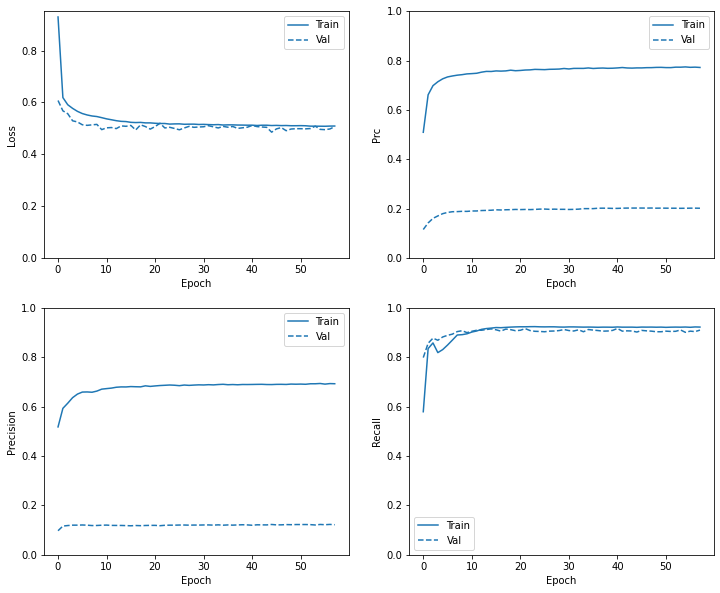

In [55]:
plot_metrics(resampled_history)

### Re-train


Because training is easier on the balanced data, the above training procedure may overfit quickly. 

So break up the epochs to give the `callbacks.EarlyStopping` finer control over when to stop training.

In [56]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 9s 232ms/step - loss: 2.1371 - tp: 4577.8095 - fp: 14106.8095 - tn: 25144.9048 - fn: 8266.9524 - accuracy: 0.5753 - precision: 0.2339 - recall: 0.3818 - mcc: -0.0177 - f2: 0.1286 - specificity: 0.7262 - ntp: 1287.1727 - nfn: 3688.5611 - nfp: 1373.9964 - ntn: 3648.1926 - fbeta_score: 0.5850 - auc: 0.5043 - prc: 0.2753 - val_loss: 0.7577 - val_tp: 618.0000 - val_fp: 9881.0000 - val_tn: 18130.0000 - val_fn: 1037.0000 - val_accuracy: 0.6320 - val_precision: 0.0589 - val_recall: 0.3734 - val_mcc: 0.0102 - val_f2: 0.0208 - val_specificity: 0.6470 - val_ntp: 209.0000 - val_nfn: 349.5333 - val_nfp: 3332.2666 - val_ntn: 6107.3335 - val_fbeta_score: 0.2280 - val_auc: 0.5206 - val_prc: 0.0590
Epoch 2/1000
20/20 [==============================] - 2s 115ms/step - loss: 1.3551 - tp: 4590.5238 - fp: 4339.9048 - tn: 6891.8571 - fn: 6608.1905 - accuracy: 0.5108 - precision: 0.5135 - recall: 0.4070 - mcc: 0.0221 - f2: 0.2034 - specificity: 0.6146 - n

20/20 [==============================] - 2s 118ms/step - loss: 0.5894 - tp: 9791.0952 - fp: 6123.3333 - tn: 5034.8571 - fn: 1481.1905 - accuracy: 0.6597 - precision: 0.6135 - recall: 0.8685 - mcc: 0.3505 - f2: 0.4355 - specificity: 0.4497 - ntp: 4354.6170 - nfn: 658.9967 - nfp: 2742.7599 - ntn: 2241.4459 - fbeta_score: 0.8341 - auc: 0.7410 - prc: 0.7034 - val_loss: 0.5583 - val_tp: 1448.0000 - val_fp: 10817.0000 - val_tn: 17194.0000 - val_fn: 207.0000 - val_accuracy: 0.6284 - val_precision: 0.1181 - val_recall: 0.8749 - val_mcc: 0.2283 - val_f2: 0.0488 - val_specificity: 0.6142 - val_ntp: 489.2000 - val_nfn: 69.3333 - val_nfp: 3641.0667 - val_ntn: 5798.4668 - val_fbeta_score: 0.2280 - val_auc: 0.7992 - val_prc: 0.1578
Epoch 24/1000
20/20 [==============================] - 2s 116ms/step - loss: 0.5848 - tp: 9719.7143 - fp: 6077.6190 - tn: 5126.0000 - fn: 1507.1429 - accuracy: 0.6597 - precision: 0.6118 - recall: 0.8648 - mcc: 0.3518 - f2: 0.4303 - specificity: 0.4566 - ntp: 4302.8264 - 

20/20 [==============================] - 2s 92ms/step - loss: 0.5569 - tp: 9788.2857 - fp: 5332.0000 - tn: 5968.8095 - fn: 1341.3810 - accuracy: 0.7026 - precision: 0.6479 - recall: 0.8789 - mcc: 0.4348 - f2: 0.4364 - specificity: 0.5288 - ntp: 4364.1133 - nfn: 600.7555 - nfp: 2371.8926 - ntn: 2661.5033 - fbeta_score: 0.8314 - auc: 0.7779 - prc: 0.7326 - val_loss: 0.5138 - val_tp: 1454.0000 - val_fp: 10608.0000 - val_tn: 17403.0000 - val_fn: 201.0000 - val_accuracy: 0.6356 - val_precision: 0.1205 - val_recall: 0.8785 - val_mcc: 0.2345 - val_f2: 0.0490 - val_specificity: 0.6219 - val_ntp: 491.3333 - val_nfn: 67.0000 - val_nfp: 3569.2000 - val_ntn: 5870.1333 - val_fbeta_score: 0.2280 - val_auc: 0.8141 - val_prc: 0.1831
Epoch 46/1000
20/20 [==============================] - 2s 124ms/step - loss: 0.5569 - tp: 9815.7143 - fp: 5377.9048 - tn: 5920.2381 - fn: 1316.6190 - accuracy: 0.7008 - precision: 0.6451 - recall: 0.8817 - mcc: 0.4329 - f2: 0.4372 - specificity: 0.5230 - ntp: 4371.3307 - n

20/20 [==============================] - 2s 97ms/step - loss: 0.5479 - tp: 10252.3333 - fp: 5492.8571 - tn: 5678.3333 - fn: 1006.9524 - accuracy: 0.7090 - precision: 0.6490 - recall: 0.9093 - mcc: 0.4563 - f2: 0.4543 - specificity: 0.5089 - ntp: 4542.2088 - nfn: 452.4643 - nfp: 2456.5780 - ntn: 2546.8951 - fbeta_score: 0.8331 - auc: 0.7847 - prc: 0.7384 - val_loss: 0.5243 - val_tp: 1500.0000 - val_fp: 11186.0000 - val_tn: 16825.0000 - val_fn: 155.0000 - val_accuracy: 0.6177 - val_precision: 0.1182 - val_recall: 0.9063 - val_mcc: 0.2366 - val_f2: 0.0506 - val_specificity: 0.6014 - val_ntp: 507.4000 - val_nfn: 51.1333 - val_nfp: 3762.7334 - val_ntn: 5677.0000 - val_fbeta_score: 0.2280 - val_auc: 0.8186 - val_prc: 0.1891
Epoch 68/1000
20/20 [==============================] - 2s 123ms/step - loss: 0.5497 - tp: 10094.8571 - fp: 5553.1429 - tn: 5787.6190 - fn: 994.8571 - accuracy: 0.7063 - precision: 0.6432 - recall: 0.9107 - mcc: 0.4552 - f2: 0.4498 - specificity: 0.5067 - ntp: 4498.1546 - 

20/20 [==============================] - 2s 109ms/step - loss: 0.5372 - tp: 10235.7619 - fp: 5326.0952 - tn: 5936.4286 - fn: 932.1905 - accuracy: 0.7206 - precision: 0.6573 - recall: 0.9169 - mcc: 0.4807 - f2: 0.4565 - specificity: 0.5259 - ntp: 4565.0439 - nfn: 413.2998 - nfp: 2379.9347 - ntn: 2639.7022 - fbeta_score: 0.8322 - auc: 0.7922 - prc: 0.7499 - val_loss: 0.4964 - val_tp: 1494.0000 - val_fp: 11006.0000 - val_tn: 17005.0000 - val_fn: 161.0000 - val_accuracy: 0.6236 - val_precision: 0.1195 - val_recall: 0.9027 - val_mcc: 0.2384 - val_f2: 0.0504 - val_specificity: 0.6077 - val_ntp: 505.4000 - val_nfn: 53.0667 - val_nfp: 3702.5334 - val_ntn: 5736.9331 - val_fbeta_score: 0.2280 - val_auc: 0.8210 - val_prc: 0.1915
Epoch 90/1000
20/20 [==============================] - 2s 98ms/step - loss: 0.5344 - tp: 10394.1429 - fp: 5176.0952 - tn: 5882.0952 - fn: 978.1429 - accuracy: 0.7255 - precision: 0.6667 - recall: 0.9132 - mcc: 0.4841 - f2: 0.4614 - specificity: 0.5338 - ntp: 4613.7528 - n

20/20 [==============================] - 2s 97ms/step - loss: 0.5310 - tp: 10293.0000 - fp: 5126.0952 - tn: 6112.3810 - fn: 899.0000 - accuracy: 0.7306 - precision: 0.6656 - recall: 0.9202 - mcc: 0.4997 - f2: 0.4573 - specificity: 0.5433 - ntp: 4572.5251 - nfn: 396.2320 - nfp: 2296.7165 - ntn: 2732.5016 - fbeta_score: 0.8316 - auc: 0.7977 - prc: 0.7525 - val_loss: 0.5107 - val_tp: 1516.0000 - val_fp: 11313.0000 - val_tn: 16698.0000 - val_fn: 139.0000 - val_accuracy: 0.6140 - val_precision: 0.1182 - val_recall: 0.9160 - val_mcc: 0.2386 - val_f2: 0.0511 - val_specificity: 0.5967 - val_ntp: 513.0000 - val_nfn: 45.5333 - val_nfp: 3807.1333 - val_ntn: 5632.3999 - val_fbeta_score: 0.2280 - val_auc: 0.8229 - val_prc: 0.1945
Epoch 112/1000
20/20 [==============================] - 2s 95ms/step - loss: 0.5285 - tp: 10306.5238 - fp: 5064.2857 - tn: 6152.3810 - fn: 907.2857 - accuracy: 0.7347 - precision: 0.6716 - recall: 0.9200 - mcc: 0.5050 - f2: 0.4607 - specificity: 0.5488 - ntp: 4606.8656 - n

20/20 [==============================] - 2s 87ms/step - loss: 0.5254 - tp: 10364.6190 - fp: 5032.0952 - tn: 6198.9524 - fn: 834.8095 - accuracy: 0.7393 - precision: 0.6733 - recall: 0.9264 - mcc: 0.5165 - f2: 0.4618 - specificity: 0.5531 - ntp: 4617.8407 - nfn: 366.2125 - nfp: 2240.1172 - ntn: 2773.7165 - fbeta_score: 0.8325 - auc: 0.8011 - prc: 0.7598 - val_loss: 0.5037 - val_tp: 1515.0000 - val_fp: 11262.0000 - val_tn: 16749.0000 - val_fn: 140.0000 - val_accuracy: 0.6157 - val_precision: 0.1186 - val_recall: 0.9154 - val_mcc: 0.2392 - val_f2: 0.0511 - val_specificity: 0.5986 - val_ntp: 512.3333 - val_nfn: 46.2000 - val_nfp: 3788.5334 - val_ntn: 5651.0669 - val_fbeta_score: 0.2280 - val_auc: 0.8250 - val_prc: 0.1970
Epoch 134/1000
20/20 [==============================] - 2s 96ms/step - loss: 0.5298 - tp: 10465.5238 - fp: 5034.3333 - tn: 6099.6190 - fn: 831.0000 - accuracy: 0.7389 - precision: 0.6760 - recall: 0.9272 - mcc: 0.5137 - f2: 0.4682 - specificity: 0.5470 - ntp: 4681.4367 - n

20/20 [==============================] - 2s 128ms/step - loss: 0.5195 - tp: 10453.4286 - fp: 4896.0476 - tn: 6253.0952 - fn: 827.9048 - accuracy: 0.7454 - precision: 0.6824 - recall: 0.9266 - mcc: 0.5248 - f2: 0.4675 - specificity: 0.5610 - ntp: 4674.5334 - nfn: 369.6382 - nfp: 2175.1740 - ntn: 2778.5845 - fbeta_score: 0.8358 - auc: 0.8064 - prc: 0.7678 - val_loss: 0.4994 - val_tp: 1506.0000 - val_fp: 11102.0000 - val_tn: 16909.0000 - val_fn: 149.0000 - val_accuracy: 0.6207 - val_precision: 0.1194 - val_recall: 0.9100 - val_mcc: 0.2396 - val_f2: 0.0508 - val_specificity: 0.6043 - val_ntp: 509.0000 - val_nfn: 49.5333 - val_nfp: 3734.5334 - val_ntn: 5705.0000 - val_fbeta_score: 0.2280 - val_auc: 0.8254 - val_prc: 0.1978
Epoch 156/1000
20/20 [==============================] - 2s 128ms/step - loss: 0.5234 - tp: 10292.7619 - fp: 4978.0476 - tn: 6302.8095 - fn: 856.8571 - accuracy: 0.7409 - precision: 0.6747 - recall: 0.9237 - mcc: 0.5190 - f2: 0.4588 - specificity: 0.5604 - ntp: 4587.5135 -

20/20 [==============================] - 2s 86ms/step - loss: 0.5286 - tp: 10323.9524 - fp: 4976.0000 - tn: 6265.1429 - fn: 865.3810 - accuracy: 0.7394 - precision: 0.6759 - recall: 0.9208 - mcc: 0.5135 - f2: 0.4609 - specificity: 0.5575 - ntp: 4608.1417 - nfn: 395.9679 - nfp: 2209.4032 - ntn: 2784.6272 - fbeta_score: 0.8336 - auc: 0.7970 - prc: 0.7549 - val_loss: 0.4967 - val_tp: 1502.0000 - val_fp: 11050.0000 - val_tn: 16961.0000 - val_fn: 153.0000 - val_accuracy: 0.6224 - val_precision: 0.1197 - val_recall: 0.9076 - val_mcc: 0.2389 - val_f2: 0.0506 - val_specificity: 0.6062 - val_ntp: 507.0000 - val_nfn: 51.4667 - val_nfp: 3716.8667 - val_ntn: 5722.7334 - val_fbeta_score: 0.2280 - val_auc: 0.8262 - val_prc: 0.1991
Epoch 178/1000
20/20 [==============================] - 2s 93ms/step - loss: 0.5215 - tp: 10367.4286 - fp: 4893.2857 - tn: 6301.7143 - fn: 868.0476 - accuracy: 0.7435 - precision: 0.6800 - recall: 0.9216 - mcc: 0.5208 - f2: 0.4616 - specificity: 0.5648 - ntp: 4615.1863 - n

20/20 [==============================] - 3s 133ms/step - loss: 0.5229 - tp: 10326.0952 - fp: 4908.2381 - tn: 6345.1429 - fn: 851.0000 - accuracy: 0.7426 - precision: 0.6777 - recall: 0.9233 - mcc: 0.5209 - f2: 0.4606 - specificity: 0.5628 - ntp: 4605.1008 - nfn: 382.1379 - nfp: 2190.4378 - ntn: 2820.2111 - fbeta_score: 0.8327 - auc: 0.8047 - prc: 0.7613 - val_loss: 0.4945 - val_tp: 1502.0000 - val_fp: 10979.0000 - val_tn: 17032.0000 - val_fn: 153.0000 - val_accuracy: 0.6248 - val_precision: 0.1203 - val_recall: 0.9076 - val_mcc: 0.2403 - val_f2: 0.0506 - val_specificity: 0.6088 - val_ntp: 507.0000 - val_nfn: 51.5333 - val_nfp: 3692.7334 - val_ntn: 5746.7334 - val_fbeta_score: 0.2280 - val_auc: 0.8272 - val_prc: 0.2004
Epoch 200/1000
20/20 [==============================] - 2s 116ms/step - loss: 0.5197 - tp: 10396.5238 - fp: 4848.4286 - tn: 6320.2381 - fn: 865.2857 - accuracy: 0.7449 - precision: 0.6818 - recall: 0.9233 - mcc: 0.5230 - f2: 0.4641 - specificity: 0.5644 - ntp: 4640.0571 -

20/20 [==============================] - 2s 103ms/step - loss: 0.5164 - tp: 10297.5238 - fp: 4865.3810 - tn: 6417.9524 - fn: 849.6190 - accuracy: 0.7446 - precision: 0.6777 - recall: 0.9242 - mcc: 0.5258 - f2: 0.4582 - specificity: 0.5681 - ntp: 4581.1881 - nfn: 375.2000 - nfp: 2178.3412 - ntn: 2863.2350 - fbeta_score: 0.8309 - auc: 0.8084 - prc: 0.7641 - val_loss: 0.5006 - val_tp: 1501.0000 - val_fp: 10965.0000 - val_tn: 17046.0000 - val_fn: 154.0000 - val_accuracy: 0.6252 - val_precision: 0.1204 - val_recall: 0.9069 - val_mcc: 0.2403 - val_f2: 0.0506 - val_specificity: 0.6093 - val_ntp: 506.6667 - val_nfn: 51.8667 - val_nfp: 3688.3333 - val_ntn: 5751.2666 - val_fbeta_score: 0.2280 - val_auc: 0.8275 - val_prc: 0.2022
Epoch 222/1000
20/20 [==============================] - 3s 130ms/step - loss: 0.5209 - tp: 10364.0476 - fp: 4896.9524 - tn: 6288.0476 - fn: 881.4286 - accuracy: 0.7414 - precision: 0.6779 - recall: 0.9211 - mcc: 0.5173 - f2: 0.4610 - specificity: 0.5615 - ntp: 4609.3340 -

### Re-check training history

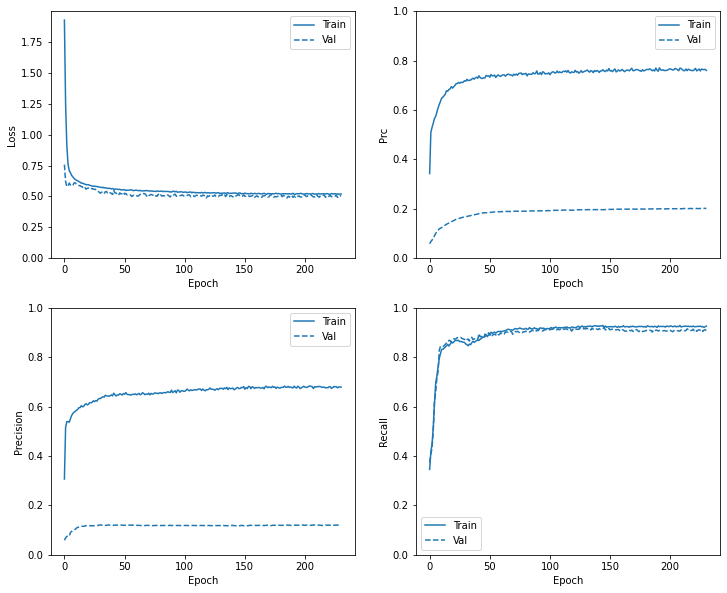

In [57]:
plot_metrics(resampled_history)

### Evaluate metrics

In [58]:
train_predictions_resampled = resampled_model.predict(X_train_f, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(X_test_f, batch_size=BATCH_SIZE)

In [59]:
def fbeta2 (prec, recall):
    return (5 * prec * recall)/(4 * prec + recall)

In [60]:
resampled_results = resampled_model.evaluate(X_test_f, y_test_l,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)

zip_iter = zip(resampled_model.metrics_names, resampled_results)
metric_dict = dict(zip_iter)
p = metric_dict['precision']
r = metric_dict['recall']
f2 = fbeta2(p, r)
print(f'f2 = {f2}')

loss :  0.4954202175140381
tp :  1888.0
fp :  13569.0
tn :  21445.0
fn :  181.0
accuracy :  0.6292101740837097
precision :  0.12214531004428864
recall :  0.9125181436538696
mcc :  0.24403499066829681
f2 :  0.05091281235218048
specificity :  0.6135106682777405
ntp :  506.15789794921875
nfn :  48.21052551269531
nfp :  3649.684326171875
ntn :  5794.10546875
fbeta_score :  0.22806939482688904
auc :  0.8257828950881958
prc :  0.19649843871593475
f2 = 0.3977584062340967


True Negatives 21445
False Positives:  13569
False Negatives 181
True Positives 1888
Total Positives:  2069


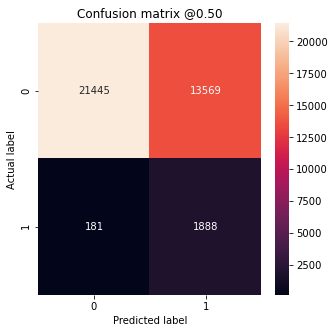

In [61]:
plot_cm(y_test_l, test_predictions_resampled)

### Plot the ROC

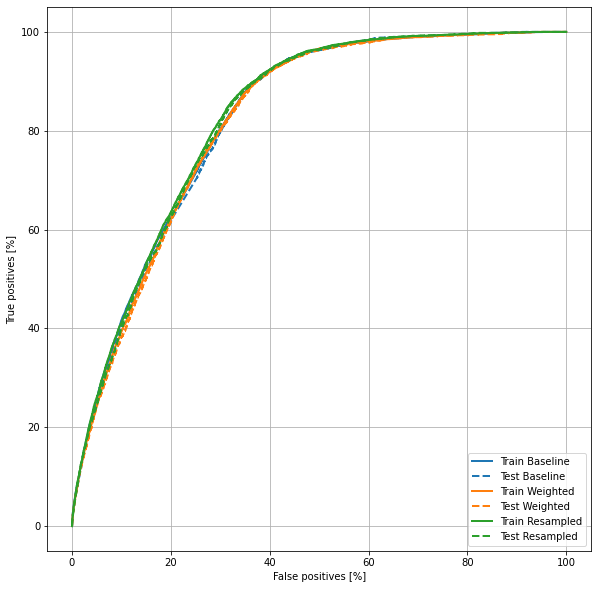

In [62]:
plot_roc("Train Baseline", y_train_l, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test_l, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train_l, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test_l, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", y_train_l, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", y_test_l, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

### Plot the AUPRC


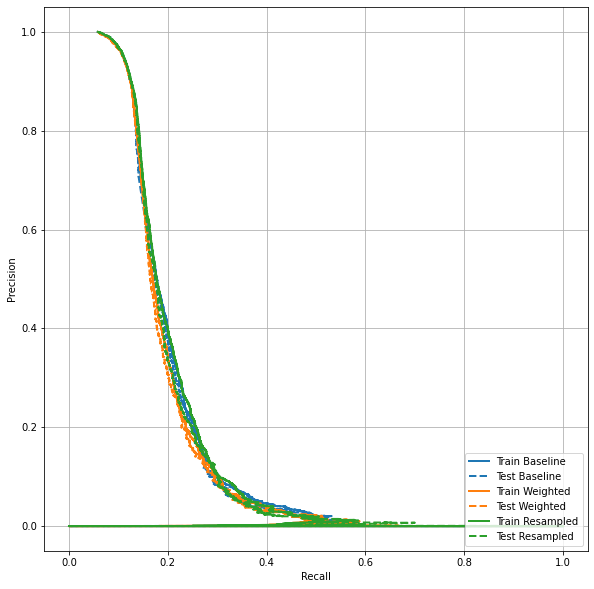

In [63]:
plot_prc("Train Baseline", y_train_l, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test_l, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train_l, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test_l, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", y_train_l, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", y_test_l, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

## Applying this tutorial to your problem

Imbalanced data classification is an inherently difficult task since there are so few samples to learn from. You should always start with the data first and do your best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point your model may struggle to improve and yield the results you want, so it is important to keep in mind the context of your problem and the trade offs between different types of errors.